In [1]:
import getpass
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
import pandas as pd
from io import StringIO
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage, AIMessage, SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import json
# os.environ["OPENAI_API_KEY"] = getpass.getpass('Password: ')
api_key = "sk-pzmVDXe1-rxgtV34fEob57Owp9b7Z7_k-jYKmFaguDT3BlbkFJXR835WsPGSV7P_sjJXS2QGOJBIxgW5wSzwqExklvAA"

from langchain_openai import ChatOpenAI

llm_1 = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)
llm_2 = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

In [38]:
class State(TypedDict):
    messages: list
    task_info_dict: dict # (df_name, df_info, file_name)
    judge_string: str

class MgrBot:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        message = state["messages"][-1] if len(state.get("messages", [])) > 0 else ""
        system = f"""You are a manager of a application with many tasks. 
You are allowed to do one of those jobs based on user's query:
1. introduce the overall general about tasks that this application can support.
2. introduce the selected task by user in detail.
3. give some advice to help user to choose one task based on his/her needs.
4. if user makes a decision to select a task to work on, then based on contexts choose one supported task that is mostly close to the user's needs and only return the task name.
All the responeses except the task name string must be in Japanese.
        """
        judge_str = state["judge_string"]
        if judge_str in["general introduction", "advice", "select"]:
            task_template = """'{task_name}': {task_explaination}"""
            all_task_info = "\n".join(task_template.format(
                task_name=task["タスク名前"], task_explaination=task["タスク説明"]
            ) for task in state["task_info_dict"].values())
            system += "\nAll the available tasks are as below\n"
            system += all_task_info
        elif judge_str == "others":
            state["messages"].append(AIMessage("申し訳ございません。業務に関する内容を聞いていただきます。"))
        else:
            file_template = """
            'ファイル名前': {file_name}
            'ファイル説明': {file_explanation}
            '必要': {needed}
            """
            task = state["task_info_dict"].get(state["judge_str"], None)
            if task is None:
                system = system
            else:
                system += f"\nFor the task {task['タスク名前']}: {task['タスク説明']}. All the required files are as below\n"
                all_file_info = "\n".join(file_template.format(
                    file_name=file["ファイル名前"], file_explanation=file["file_explanation"],
                    needed = file["必要"]) for file in task["必要なファイル"]
                )
                system += all_file_info
        # TODO: check whether need to add the original code in the prompt
        prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
        state["messages"].append((prompt | self.llm).invoke(message.content))
        return state
    
class JudgeBot:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        message = state["messages"][-1] if len(state.get("messages", [])) > 0 else ""
        system = f"""You are a content judger, and you are required to judge the type of a given content.
1. If the content is about general introduction, return a string "general introduction"
2. If the content is related to one specific task introduction, just return the task name
3. If the content is about asking advice about how to select a task, return a string "advice"
4. If the content is about making a decision to select a task to work on, return a string "select"
5. If none of the above, return a string "others"
        """
        task_template = """'{task_name}': {task_explaination}"""
        all_task_info = "\n".join(task_template.format(
            task_name=task["タスク名前"], task_explaination=task["タスク説明"]
        ) for task in state["task_info_dict"].values())
        system += "\nAll the available tasks are as below\n"
        system += all_task_info

        prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
        response = (prompt | self.llm).invoke(message.content)
        state["judge_string"] = response.content
        return state

In [39]:
graph_builder = StateGraph(State)
mgrbot = MgrBot(llm=llm_1)
judgebot = JudgeBot(llm=llm_2)
graph_builder.add_node("mgr", mgrbot)
graph_builder.add_node("judge", judgebot)
graph_builder.add_edge(START, "judge")
graph_builder.add_edge("judge", "mgr")
graph_builder.add_edge("mgr", END)
graph = graph_builder.compile()

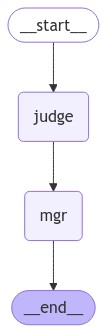

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [40]:
def create_init_state(json_file_path, prompt):
    task_dict = {}
    with open(json_file_path, 'r') as f:
        origin_dict = json.load(f)
        for task in origin_dict["タスク"]:
            task_dict[task["タスク名前"]] = task
    message_list = [HumanMessage(prompt)]
    state = State(messages=message_list, task_info_dict=task_dict, judge_string=None)
    return state

In [41]:
prompt = "全体のタスクを紹介してください"
json_file_path = "/Users/formaideveloper/LLM_excel/application_v3/json/config.json"
init_state = create_init_state(json_file_path, prompt)

In [42]:
res = graph.stream(init_state)
for event in res:
    for v in event.values(): # Here is to handle the situation of multiple nodes at this stage
        final_state = v
for message in final_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))
print(final_state["judge_string"])

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションでは、以下のタスクをサポートしています：

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除と漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）の作成を行います。
4. **納品物作成2-1-2**: Yonosukeの不要行の削除を行います。
5. **納品物作成2-2-1**: 給与支給控除一覧データの雛形作成と振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータ更新を行います。

これらのタスクは、さまざまな業務ニーズに対応しており、特定の要件に基づいて作業を行うことができます。どのタスクについて詳しく知りたいですか？
------------------------------------------------------------
general introduction


In [15]:
init_state["messages"].append(HumanMessage("納品物作成1-1をもっと紹介してください。"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------


In [16]:
init_state["messages"].append(HumanMessage("なんのファイル必要ですか？"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------
なんのファイル必要ですか？
------------------------------------------------------------
このアプリケーションは、さまざまなタスクをサポートしています。具体的には、納品物の作成やデータの更新、不要行の削除、漢字の変換など、複数の

In [17]:
init_state["messages"].append(HumanMessage("納品物作成1-1はなんのファイル必要ですか？"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------
なんのファイル必要ですか？
------------------------------------------------------------
このアプリケーションは、さまざまなタスクをサポートしています。具体的には、納品物の作成やデータの更新、不要行の削除、漢字の変換など、複数の

In [18]:
init_state["messages"].append(HumanMessage("現在流行っているゲームを紹介してください"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------
なんのファイル必要ですか？
------------------------------------------------------------
このアプリケーションは、さまざまなタスクをサポートしています。具体的には、納品物の作成やデータの更新、不要行の削除、漢字の変換など、複数の

In [19]:
init_state["messages"].append(HumanMessage("納品物作成2いくつのタスクがありますか？"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------
なんのファイル必要ですか？
------------------------------------------------------------
このアプリケーションは、さまざまなタスクをサポートしています。具体的には、納品物の作成やデータの更新、不要行の削除、漢字の変換など、複数の

In [20]:
init_state["messages"].append(HumanMessage("では、納品物作成2-2-2を選びます。"))
res = graph.stream(init_state)
for event in res:
    pass
for message in init_state['messages']:
    print(message.content)
    print("".join("-" for _ in range(60)))

全体のタスクを紹介してください
------------------------------------------------------------
このアプリケーションは、以下のタスクをサポートしています。

1. **納品物作成1-1**: 4項目の数値更新を行います。
2. **納品物作成1-2**: 不要行の削除および漢字変換を行います。
3. **納品物作成2-1-1**: Yonosukeデータ（年間累計課税支給額データ）を作成します。
4. **納品物作成2-1-2**: Yonosukeの不要行を削除します。
5. **納品物作成2-2-1**: 【給与】支給控除一覧データの雛形作成および振込先加工を行います。
6. **納品物作成2-2-2**: 当月退職者のデータを更新します。

これらのタスクは、主にデータの管理や更新、不要な情報の整理に役立ちます。どのタスクに興味がありますか？
------------------------------------------------------------
納品物作成1-1をもっと紹介してください。
------------------------------------------------------------
納品物作成1-1は、4項目の数値を更新するためのタスクです。このタスクは、特定のデータセットに対して数値を正確に更新することを目的としています。主に、報告書や資料の納品物を作成する際に必要なデータの修正や更新を行います。これにより、最新の情報に基づいた納品物を作成することができ、業務の効率化や正確性を向上させることができます。

このタスクを利用することで、データの整合性を保ちつつ、迅速に納品物を準備することが可能です。特に数値データの管理や更新が必要な場合には非常に便利です。
------------------------------------------------------------
なんのファイル必要ですか？
------------------------------------------------------------
このアプリケーションは、さまざまなタスクをサポートしています。具体的には、納品物の作成やデータの更新、不要行の削除、漢字の変換など、複数の